# Quantitative segmentation quality estimation

Often we  face the problem, that we have an annnotated image of some data and a segmented version of the same image, which was obtained with some segmentation pipeline (StarDist, EPySeg, PlantSeg, etc). This notebook provides a method to compare the overlap of both ground truth image and achieved segmentation.

In [250]:
import os
import biapol_utilities as biau
from skimage import io, measure, segmentation, feature, util
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from scipy import ndimage as ndi

%matplotlib notebook

##  Input data
First, load example data.

*Important note*: The input data **must** be binarized image data for this script to work, i.e. probability maps will not work. Probability maps generated with EpySeg or Ilastik can simply be thresholded using a threshold value of 0.5. It is also recommended to do a simple step of morphological smoothing, such as [erosion/dilation](https://clij.github.io/clij2-docs/reference_closingBox).

In [251]:
source = r'/Users/pbreier/Documents/GitHub/quail_code/data/benchmarking/tissue/'
outdir = r'/Users/pbreier/Documents/GitHub/quail_code/data/benchmarking/tissue/output/'

ground_truth = tf.imread(os.path.join(source, 'MAX_benchmark_tissue_Simple Segmentation.tif')).astype(np.uint16)
segmented = tf.imread(os.path.join(source, 'handCorrection_small.tif')).astype(np.uint16)

Make sure that we analyze cell shapes rather than just pixel-pixel criteria. Note, that for this, cell interiors should have value 1 and cell membranes should have value 0.

In [252]:
# define function to use watershed
def watershed_own(image, kernel_size):
    distance = ndi.distance_transform_edt(image)
    coords = feature.peak_local_max(distance, footprint=np.ones((kernel_size, kernel_size)), labels=image)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    boundary = segmentation.mark_boundaries(-distance, markers)
    watershed = segmentation.watershed(-distance, markers)
    return watershed, distance, markers

In [253]:
# get watershed of segmented image
watershed, distance, markers = watershed_own(segmented, 10)

<IPython.core.display.Javascript object>


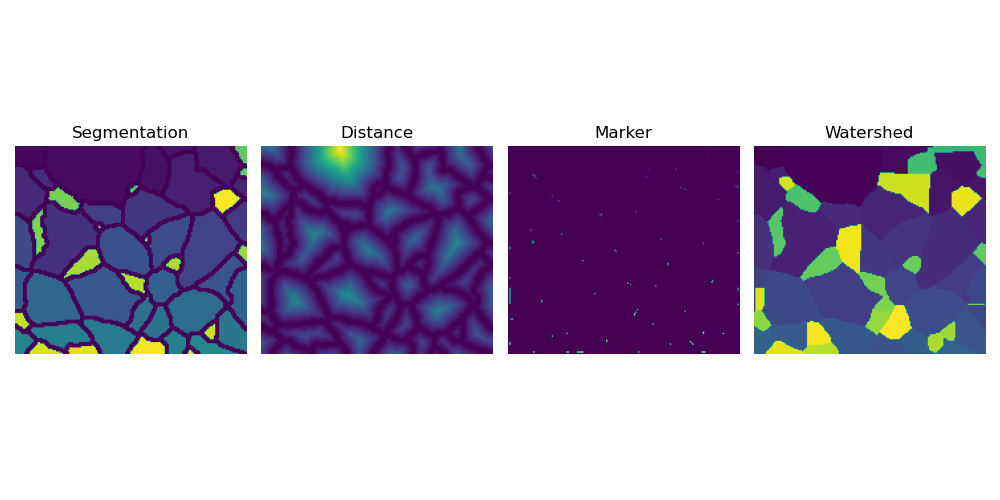

In [266]:
# display watershed
fig, axes = plt.subplots(ncols=4, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.ravel()

axes[0].imshow(segmented)
axes[0].set_title('Segmentation')

axes[1].imshow(distance)
axes[1].set_title('Distance')

axes[2].imshow(markers)
axes[2].set_title('Marker')

axes[3].imshow(watershed)
axes[3].set_title('Watershed')

for a in axes:
    a.set_axis_off()

fig.tight_layout()
fig.savefig(os.path.join(outdir, '1_seg_vs_watershed.png'))

In [255]:
#make images integer
segmented = segmented.astype(np.uint16)
ground_truth = ground_truth.astype(np.uint16)

In [256]:
#measure labels not pixels
ground_truth = measure.label(ground_truth)
segmented = measure.label(segmented)
watershed = measure.label(watershed)

In [257]:
#match labels
segmented = biau.label.match_labels(ground_truth, segmented)
watershed = biau.label.match_labels(ground_truth, watershed)

/Users/pbreier/Documents/GitHub/quail_code/notebooks/biapol_utilities/label/_intersection_over_union.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)


<IPython.core.display.Javascript object>


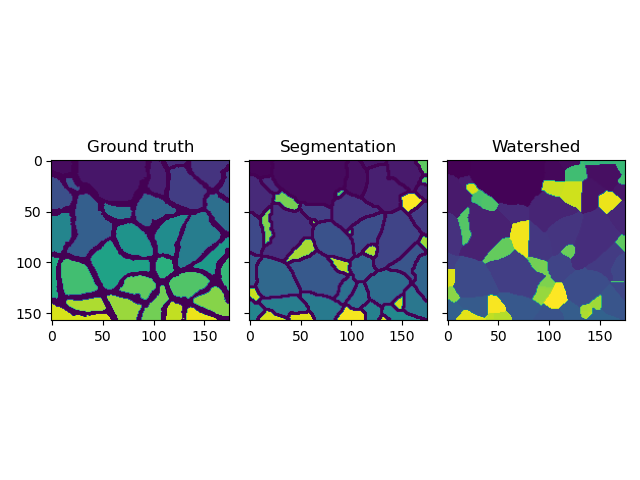

In [258]:
z_visualize = 1

# Plot side by side
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True)

axes[0].imshow(ground_truth)
axes[0].set_title('Ground truth')

axes[1].imshow(segmented)
axes[1].set_title('Segmentation')

axes[2].imshow(watershed)
axes[2].set_title('Watershed')

fig.tight_layout()
fig.savefig(os.path.join(outdir, '0_gt_vs_seg.png'))

## Compare labels:  Labelwise Jaccard-index

Lastly, we calculate the *label-wise Jaccard index* to measure the intersection over union (IoU) between corresponding pairs of labels.

In [259]:
result = biau.label.compare_labels(ground_truth, segmented)
result_watershed = biau.label.compare_labels(ground_truth, watershed)

# It makes no sense to keep unmatche labels in results dataframe
result_no_zeros = result[result['jaccard_score'] != 0]
result_watershed_no_zeros = result_watershed[result_watershed['jaccard_score'] != 0]

In [260]:
print('Mean jaccard standard: {:.2f} +/- {:.2f}, watershed {:.2f} +/- {:.2f}'.format(result_no_zeros.jaccard_score.mean(), result_no_zeros.jaccard_score.std(), result_watershed_no_zeros.jaccard_score.mean(), result_watershed_no_zeros.jaccard_score.std()))
print('Mean Dice standard: {:.2f} +/- {:.2f}, watershed {:.2f} +/- {:.2f}'.format(result_no_zeros.dice_score.mean(), result_no_zeros.dice_score.std(), result_watershed_no_zeros.dice_score.mean(), result_watershed_no_zeros.dice_score.std()))

Mean jaccard standard: 0.69 +/- 0.17, watershed 0.55 +/- 0.14
Mean Dice standard: 0.81 +/- 0.13, watershed 0.70 +/- 0.12


Let's also visualize this: To do this, we create a new image and assign the jaccard-index result value to every pixel depending on the label.

In [261]:
LUT_jaccard = np.arange(0, result.label.max()+1, 1)
LUT_dice = np.arange(0, result.label.max()+1, 1)

In [262]:
type(result.label)

pandas.core.series.Series

In [263]:
LUT_jaccard[result.label = result['jaccard_score'].to_numpy()
LUT_dice[result.label = result['dice_score'].to_numpy()

# set segmentation quality of background to zero
LUT_jaccard[0] = np.nan
LUT_dice[0] = np.nan

# create score map
JI_map = LUT_jaccard[segmented]
DI_map = LUT_dice[segmented]

SyntaxError: invalid syntax (620701225.py, line 1)

This visualization shows the ground truth and the segmennnted image separately in a selected slice and as an overlay. Also, the bottom images visualizes the single segmented cells with their color coding their jaccard or dice indeces, respectively. The segented image is used to visualize the jaccard/dice coefficients.

In [ ]:
# Plot side by side
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))
fig.subplots_adjust(left=0.05, bottom=0.06, right=0.85, top=0.95, wspace=0.05)


# Plot ground truth
axes[0, 0].imshow(ground_truth)
axes[0, 0].set_title('Ground truth')

# Plot segmentation
axes[0, 1].imshow(segmented)
axes[0, 1].set_title('Segmentation')

# Plot overlay
axes[0, 2].imshow(ground_truth)
axes[0, 2].imshow(segmented[z_visualize], alpha=0.5)
axes[0, 2].set_title('Overlay')

# Plot Jaccard index map
im = axes[1, 0].imshow(JI_map, cmap='inferno')
axes[1, 0].set_title('Jaccard score')
cbar = fig.colorbar(im, ax=axes[1, 0])

# Plot Dice score map
im2 = axes[1, 1].imshow(DI_map, cmap='inferno')
axes[1, 1].set_title('Dice score')
cbar2 = fig.colorbar(im2, ax=axes[1, 1])

axes[-1, -1].axis('off')

fig.savefig(os.path.join(outdir, '1_Jaccard_dice_map.png'))

## Compare-labels: Feature-wise
It may be an interesting approach to not only check the pixel-wise agreement between segmentation and annnootation but to also check whether certain features are preserved in the segmentation. For this, the (shape-) features are calculated in both ground_truth annotation and segmented image with scikit-image regionprops.

This parameter determines whether the object features will be determined in 2D or 3D. Some parameters are not implemented in 3D, so 2D may be a better choice.

In [ ]:
Measure = '2D'

In [ ]:
features_gt = []
features_seg = []
if Measure == '2D':
    properties = ['label', 'area', 'eccentricity']
    for  z in range(ground_truth.shape[0]):
        _features_gt = measure.regionprops_table(ground_truth[z], properties=properties)
        _features_seg = measure.regionprops_table(segmented[z], properties=properties)

        _features_gt = pd.DataFrame(_features_gt)
        _features_seg = pd.DataFrame(_features_seg)

        features_gt.append(_features_gt)
        features_seg.append(_features_seg)

    features_gt = pd.concat(features_gt)
    features_seg = pd.concat(features_seg)

Visualize as histograms

In [ ]:
fig = plt.figure()

ax_idx = 0
for idx, prop in enumerate(properties):
    if  prop == 'label':
        continue
    
    ax = fig.add_subplot(1, len(properties)-1, idx)
    
    ax.hist(features_gt[prop], label='ground_truth', bins=len(features_gt)//10, alpha=0.5)
    ax.hist(features_seg[prop], label='segmentation', bins=len(features_gt)//10, alpha=0.5)
    ax.set_xlabel(prop)
    
    ax.legend()
    ax.set_ylabel('# Occurrences')
    
fig.savefig(os.path.join(outdir, '2_histograms.png'))